## 03 Modeling  

(introduction here)

### Skip Ahead:  

[Model 1](#Model-1)  
[Model 2](#Model-2)  
[Model 3](#Model-3)  
[Model 4](#Model-4)  
[Model 5](#Model-5)  
[Significant Words](#Significant-Words)  
[Model 6](#Model-6)  
[Coefficient Considerations](#Coefficient-Considerations)  
[Model 7](#Model-7)  
[Model 8](#Model-8)  
[Model 9](#Model-9)  
[Model 10](#Model-10)  

In [1]:
#imports
#common code:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
#week 3
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#week 4
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#week 5
import requests
from bs4 import BeautifulSoup
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [2]:
df = pd.read_csv('./sub_data/clean_subs.csv')

In [3]:
df.head() #preview

,subreddit,id,author,num_comments,selftext,title,upvote_ratio,url,all_text
0,0,jc3ty3,jaaytf_,2,hey so my xbox one is turning on and instantly...,xbox one problems:),1.0,https://www.reddit.com/r/xbox/comments/jc3ty3/...,xbox one problems:) hey so my xbox one is turn...
1,0,jc3tg4,Matty_Rts,0,"For context, I purchased game pass on Xbox One...",My Preorder download for Beyond Light Disappea...,1.0,https://www.reddit.com/r/xbox/comments/jc3tg4/...,My Preorder download for Beyond Light Disappea...
2,0,jc39t3,Rorydo44,2,I had $50 worth of gift cards in my account an...,Missing gift cards,1.0,https://www.reddit.com/r/xbox/comments/jc39t3/...,Missing gift cards I had $50 worth of gift car...
3,0,jc37vv,NonsenseText,0,Hi everyone! \n\nI would like to learn more ab...,Advice for Xbox online security?,1.0,https://www.reddit.com/r/xbox/comments/jc37vv/...,Advice for Xbox online security? Hi everyone! ...
4,0,jc36eg,Mondo-Butter-21,4,"Srsly tho, how tf did Doom Eternal get onto th...",Anyone else think it’s fucking hilarious that ...,1.0,https://www.reddit.com/r/xbox/comments/jc36eg/...,Anyone else think it’s fucking hilarious that ...


In [4]:
#referring to lesson 5.05 lecture notes

In [5]:
X = df['all_text']
y = df['subreddit']

In [6]:
y.value_counts(normalize=True)

1    0.50237
0    0.49763
Name: subreddit, dtype: float64

It looks like my distribution between the subreddits after cleaning is very close to 50/50, which is good! As a reminder, 1 is for Playstation and 0 is for Xbox.

In [7]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=17)

In [8]:
y_train.value_counts(normalize=True)

1    0.500102
0    0.499898
Name: subreddit, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

1    0.509172
0    0.490828
Name: subreddit, dtype: float64

Okay - it looks like my train and test data distribution reflects my true y distribution very well. Excellent. 

I'm going to start by CountVectorizing the data and then a Naive Bayes model. The easiest way to accomplish both will be performing them concurrently using a pipeline. I will probably want to try the Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer as well so I'm going to build a pipeline making function that can handle either.

### Model 1

In [10]:
def pipemaker(scaler, classifier):
    if scaler == 'cvec':
        item1 = ('cvec', CountVectorizer())
    elif scaler == 'tvec':
        item1 = ('tvec', TfidfVectorizer())
    else:
        return 'Error. Please enter "cvec" or "tvec"'
    if classifier == 'nb':
        item2 = ('nb', MultinomialNB())
    else:
        return 'Error. Please enter "nb"'
    return Pipeline([item1, item2])

In [11]:
pipe = pipemaker('cvec', 'nb') #test
print(pipe)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])


Rather than just picking one set of paramaters and proceeding, I'm going to pause here and write a reusable function to set paramaters so that as I tweak my model, it will be easy to update the parameters and run the model again.

In [12]:
def set_params(scaler, max_feat_list, min_df_list, max_df_list, ngram_list):
    if scaler != 'cvec' and scaler != 'tvec':
        return 'Please enter either cvec or tvec as the first item.'
    pipe_params = {f'{scaler}__max_features': max_feat_list,
              f'{scaler}__min_df': min_df_list,
              f'{scaler}__max_df': max_df_list,
              f'{scaler}__ngram_range': ngram_list}
    return pipe_params

In [13]:
set_params('cvec', [200,300,400], [2,3], [.9, .95], [(1,1), (1,2)]) #test

{'cvec__max_features': [200, 300, 400],
 'cvec__min_df': [2, 3],
 'cvec__max_df': [0.9, 0.95],
 'cvec__ngram_range': [(1, 1), (1, 2)]}

There we go - now I can enter a scaler and 4 lists and get back a parameters dictionary. I'm going to put both of these functions into a python file so I can call them in regularly without clogging up my notebook. I can also add other things the the python file as I go along if it proves helpful.

In [14]:
import p3_utils as utils #import my python file

In [15]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [16]:
maxfeats = [10_000, 20_000] #try different volume of features
mindf = [3, 5] #minimum word frequency to be included in the model
maxdf = [.9, .95] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,1),(1,2)] #range of combinations of words to try (minimum, maximum)
scaler = 'cvec'
classifier = 'nb'

#pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=4,        #use 4 cores to process faster
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

In [17]:
#gs.fit(X_train, y_train)

This would be a good place to add another function to my .py file - one that gives me the best parameters, scores training and test data, and creates a confusion matrix for me.

In [18]:
def score_model(model, X_train, y_train, X_test, y_test):
    print(f'The best parameters are: {model.best_params_}')
    print(f'The best training score was: {model.best_score_}')
    print(f'The test score is: {model.score(X_test, y_test)}')
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print('_'*20)
    print('Confusion Matrix for Test Set:')
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d');
    plt.show()
    print(f'The Accurracy score is {metrics.accuracy_score(y_test, preds)}')
    print(f'The Sensitivity score is {metrics.recall_score(y_test, preds)}')
    print(f'The Precision score is {metrics.precision_score(y_test, preds)}')
    print('_'*20)
    print('Receiver Operating Characteristic (ROC) curve:')
    metrics.plot_roc_curve(model, X_test, y_test);
    plt.show()
    return 'Model scored!'

In [19]:
#score_model(gs, X_train, y_train, X_test, y_test) #test

Looks good! I'll add that function to my utility file as well.  

Let's see how the first grid search scored:

In [20]:
#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### Here is the printout that score_model() provided (except for the graphs):

The best parameters are: {'cvec__max_df': 0.9, 'cvec__max_features': 20000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2)}  
The best training score was: 0.9050761571304051  
The test score is: 0.9062372604973502  
____________________
Confusion Matrix for Test Set: (not shown here)  

The Accurracy score is 0.9062372604973502  
The Sensitivity score is 0.9211369095276221  
The Precision score is 0.8974258970358814  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown here)  

'Model scored!'  

This says that my best model used words that appeared in 90% or less of my text, 20,000 features, and words that appeared 5 separate times or more. It also factored in single words and words that appear in pairs. The model scored 90.5% accuracy on the training data and 90.6% accuracy on the test data so no apparent bias or variance issues! The Sensitivity score is a little better than the Precision score, suggesting that my model is a little better at avoiding false negatives than avoiding false positives.  

### Model 2

I'm going to adjust some of the parameters:  
- features - my highest parameter (20k) was the best last time, let's try higher  
- mindf - my highest parameter (5) was the best last time, let's try higher  
- maxdf - the lower end of my options (.9) was the best last time, lets try lower  
- ngrams - the higher ngram counts (1,2) was optimal, let's try other, higher combinations
- same scaler (cvec) and classifier (nb)

In [21]:
maxfeats = [20_000, 30_000, 40_000] #try different volume of features
mindf = [5, 6, 7] #minimum word frequency to be included in the model
maxdf = [.8, .85, .9] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,2), (2,3), (2,4)] #range of combinations of words to try (minimum, maximum)
scaler = 'cvec'
classifier = 'nb'

#pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=4,        #use 4 cores to process faster
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() printout:

The best parameters are: {'cvec__max_df': 0.8, 'cvec__max_features': 20000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2)}  
The best training score was: 0.9050761571304051  
The test score is: 0.9062372604973502  
____________________
Confusion Matrix for Test Set: (not shown)  

The Accurracy score is 0.9062372604973502  
The Sensitivity score is 0.9211369095276221  
The Precision score is 0.8974258970358814  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown)  

'Model scored!'

Some interesting implications of this second model. The best parameters included frequencies of 80% or lower, which was the lowest possible. I'm starting to think I'm dealing with a LOT of stop words which is why the grid search continues to prefer lower frequency words. My model did not prefer a higher minimum frequency than 5 even though 6 and 7 were also tried. The ngram range also stayed the same despite some higher options being available. Most bizarrely, my scores are pretty much the same all the way through as model one, suggesting none of the changes I attempted had any real impact on model accuracy.

### Model 3  

I'm going to try removing some stop words. I have to pause here for a moment and update my set_params function in the .py file to include that hyperparameter...

In [22]:
def set_params(scaler, max_feat_list, min_df_list, max_df_list, sw_list, ngram_list):
    if scaler != 'cvec' and scaler != 'tvec':
        return 'Please enter either cvec or tvec as the first item.'
    pipe_params = {f'{scaler}__max_features': max_feat_list,
              f'{scaler}__min_df': min_df_list,
              f'{scaler}__max_df': max_df_list,
              f'{scaler}__stop_words': sw_list, #adding stop word list
              f'{scaler}__ngram_range': ngram_list}
    return pipe_params

That should do it!

In [23]:
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#https://stackabuse.com/removing-stop-words-from-strings-in-python/
import nltk
from nltk.corpus import stopwords

In [24]:
#print(stopwords.words('english'))  #preview stop word list

In [25]:
maxfeats = [15_000, 20_000, 30_000] #try different volume of features
mindf = [3, 5] #minimum word frequency to be included in the model
maxdf = [.8, .9] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,2), (1,3)] #range of combinations of words to try (minimum, maximum)
swords = [None, stopwords.words('english')] #try None and a standard stop word list
scaler = 'cvec'
classifier = 'nb'

pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=4,        #use 4 cores to process faster
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() output:

The best parameters are: {'cvec__max_df': 0.8, 'cvec__max_features': 15000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': {list of stop words}  
The test score is: 0.9076640847941296  
____________________
Confusion Matrix for Test Set: (not shown)

The Accurracy score is 0.9076640847941296  
The Sensitivity score is 0.9283426741393115  
The Precision score is 0.8943308908600077  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown)  

'Model scored!'
​

A few takewaways from model 3; the best parameters still included words under 80% frequencey, even with stop words removed. However, the max features hyperparameter of 15k was preferred to 20k which scored best in the two prior models. Minimum frequency was still best at 5, the ngram range was still (1,2), and as we might expect, using the stop word list was preferred to leaving them out. Notwithstanding all of that, my test accuracy score barely improved (about .001). I'm going to switch into the TF-IDF method and see if that makes a difference.

### Model 4  

This will be my first model using the TF-IDF vectorizer which will score word importance as a ratio. I'll just keep all the other parameters the same for comparison purposes, but I am going to save the stopwords.words('english') list as a variable. I'm also going to up my processing speed by adding a 5th core.

In [26]:
nltk_slist = stopwords.words('english')
maxfeats = [15_000, 20_000, 30_000] #try different volume of features
mindf = [3, 5] #minimum word frequency to be included in the model
maxdf = [.8, .9] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,2), (1,3)] #range of combinations of words to try (minimum, maximum)
swords = [None, nltk_slist] #try None and a standard stop word list
scaler = 'tvec' #CHANGING SCALER <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
classifier = 'nb'

pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=5,        #UPPING TO 5 CORES <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() output:  

The best parameters are: {'tvec__max_df': 0.8, 'tvec__max_features': 15000, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': stop word list}  
The best training score was: 0.8999122595621148  
The test score is: 0.8982878108438647  
____________________
Confusion Matrix for Test Set: (not shown)

The Accurracy score is 0.8982878108438647  
The Sensitivity score is 0.9099279423538831  
The Precision score is 0.8924224577934825  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown)  

'Model scored!'

Interesting. It looks like the best tvec model opted for all the same features than my previous cvec model did, but resulted in lower scores across the board.

### Model 5  

I'm going to revert to the more accurate cvec scaler for my next model. As touched upon previously, the best model seems to always pick the lowest max data frequency percentage when given a range. I'm going to try some even lower ranges and see if a)the lowest range is selected again and b)this improves accuracy in any substantial way. Also, since I added stop words in Model 3, the grid search has selected 15,000 features as ideal as opposed to 20k or 30k. I'm going to try some lower feature options and see if that makes a difference. Finally, I'm going to add some different minimum frequency options - "5" has been the most popular so I'll offer 4 and 6 as alternatives.  

I'm also going to stop testing "None" for stop words. Clearly they're helping, there's no reason to keep trying models without a stop word list going forward.

In [27]:
nltk_slist = stopwords.words('english')
maxfeats = [10_000, 12_000, 15_000, 20_000] #try different volume of features
mindf = [4, 5, 6] #minimum word frequency to be included in the model
maxdf = [.5, .6, .7, .8] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,2), (1,3)] #range of combinations of words to try (minimum, maximum)
swords = [nltk_slist] #try None and a standard stop word list
scaler = 'cvec' #back to cvec
classifier = 'nb'

pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=5,        #using 5 cores to process
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() output:  

The best parameters are: {'cvec__max_df': 0.5, 'cvec__max_features': 20000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': stop word list}  
The best training score was: 0.907522386392176  
The test score is: 0.9080717488789237  
____________________
Confusion Matrix for Test Set: (not shown)  

The Accurracy score is 0.9080717488789237  
The Sensitivity score is 0.9267413931144916  
The Precision score is 0.8962446767324816  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown)  

'Model scored!'

Some takeaways here: again, the lowest frequency was selected (0.5); max features went back up to 20k rather than 15k. Minimum data frequency adjusted to 4 instead of 5 when given the opportunity. The ideal ngram range stayed the same at (1,2). Accuracy did not improve significantly over my most accurate prior model (Model 3).

### Significant Words  

I'm going to pause modeling at this point to see which words my model (Model 5) finds to be most commonly occurring for each subreddit.

In [28]:
#https://stackoverflow.com/questions/62096337/how-do-you-find-which-words-a-trained-naive-bayes-classifier-uses-to-make-decisi
#https://stackoverflow.com/questions/24375911/how-to-print-estimated-coefficients-after-a-gridsearchcv-fit-a-model-sgdregr
#https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

NOTE: Code below commented out because making the graph would require running the grid search. Image was saved and appears in markdown (below)

In [29]:
#scale_f = gs.best_estimator_.named_steps['cvec']
#class_f = gs.best_estimator_.named_steps['nb']
#referred to lesson 5.05
#XT_df = pd.DataFrame(scale_f.fit_transform(X_train).todense(), columns = scale_f.get_feature_names())
#plt.figure(figsize=(12,5))
#plt.title('Most Frequent Words in X_train Data Set After Stop Words Removed', size=25)
#plt.xlabel('Number of Uses (out of 14,717 posts in training set)', size=20)

#XT_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
#plt.savefig('./images/m5_word_frequency', dpi=200);

![Model 5 - Most Frequent Words](./images/m5_word_frequency.png)

Some keys about this distribution:  
- 'xbox' is the most frequent word, appearing in nearly 12,000 posts. This is especially impressive since the sample is a little over 14,000 posts, of which about half are from the playstation subreddit. So while we might expect the xbox to be referenced regularly in the 7,000 xbox subreddit samples, it seems that close to 5,000 playstaion posts also reference it.  
-  'ps4' appears in less than half of the posts overall, so xbox subredditors seem to not be as regular with referencing their rival as playstation subredditors are
- aside from the system references, the other words could probably be considered stop words for a gaming subreddit (know, like, account, play, get, one, games, game). I'm going to try a new stopword list that includes those 8 and see how we do.

### Model 6

In [30]:
nltk_slist = stopwords.words('english')
nltk_slist.append(['know', 'like', 'account', 'play', 'get', 'one', 'games', 'game']) #<<<<< adding stop words
maxfeats = [12_000, 15_000, 20_000] #try different volume of features
mindf = [4, 5] #minimum word frequency to be included in the model
maxdf = [.5, .6, .7, .8] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,2), (1,3)] #range of combinations of words to try (minimum, maximum)
swords = [stopwords.words('english'), nltk_slist] #<<<<<<<<<<<<< trying standard and edited stop word lists
scaler = 'cvec' #back to cvec
classifier = 'nb'

pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=5,        #using 5 cores to process
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() output:  

The best parameters are: {'cvec__max_df': 0.5, 'cvec__max_features': 20000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': (nltk list)  
The best training score was: 0.907522386392176  
The test score is: 0.9080717488789237  
____________________
Confusion Matrix for Test Set: (not shown)  

The Accurracy score is 0.9080717488789237  
The Sensitivity score is 0.9267413931144916  
The Precision score is 0.8962446767324816  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown)  

'Model scored!'

The same maxdf, max features, mindf, and ngram range were all selected as ideal. More interestingly, my "edited" stop words list was *NOT* selected for the best model. So removing those common words was not helpful. Since this model chose all the same parameters that my last model did (Model 6), it has the same accuracy scores. Perhaps this should not be surprising, given that max df is 50%. Any words that appear in more than 50% of the posts aren't being included anyways, and that hyperparameter is probably overshadowing any stop word adjustments I make.

### Coefficient Considerations  

I'm going to try to pull out the largest coefficients from this last model.  

Again - the code will be commented out because running it would require running the grid search. My results will be put into markdown.

In [31]:
#scale_f = gs.best_estimator_.named_steps['cvec']
#class_f = gs.best_estimator_.named_steps['nb']

#coef_df = pd.DataFrame(class_f.coef_, columns = scale_f.get_feature_names())

In [32]:
#coef_df.sum().sort_values()

#### Top 25 Coefficients:

|  ngram(1,2)     |     coef |
|:----------------|---------:|
| made xbox       | -12.8359 |
| better pc       | -12.8359 |
| gp ultimate     | -12.8359 |
| problem posting | -12.8359 |
| grammar         | -12.8359 |
| beta xbox       | -12.8359 |
| beta support    | -12.8359 |
| beta pc         | -12.8359 |
| beta app        | -12.8359 |
| best xbox       | -12.8359 |
| problem headset | -12.8359 |
| green screen    | -12.8359 |
| use series      | -12.8359 |
| use gamepass    | -12.8359 |
| use use         | -12.8359 |
| group post      | -12.8359 |
| use xcloud      | -12.8359 |
| used 360        | -12.8359 |
| dating          | -12.8359 |
| price series    | -12.8359 |
| guys one        | -12.8359 |
| gwg             | -12.8359 |
| prestige        | -12.8359 |
| hall            | -12.8359 |
| hall fame       | -12.8359 |

The range of coefficients appears to run from around -4 to -12, and there are no positive coefficients. The list above shows the top 25 although they all seem to be of the same magnitude. This is odd. I'm going to see if I can isolate the best set of parameters from my grid search in the next model, and then I want to load those into a new naive bayes model (outside of a pipeline) so that it's easier to evaluate the coefficients.

### Model 7  

#### Enter the Lemmatizer

An important aspect that I have yet to attempt in my modeling is the lemmatizer option. This would reduce words to their root (i.e. "game" and "games" both reduce to "game") and might help make my model more accurate. I will lemmatize X_train and X_test and then run them through the model to see what the affect might be.

In [33]:
#from lesson 5.03 
#https://stackoverflow.com/questions/40902430/lemmatization-inside-array-using-nltk-python
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
lemmatizer = WordNetLemmatizer()

tokenizer = RegexpTokenizer(r'\w+') #create tokenizer to remove punctuation

In [34]:
X_train_tokens = [tokenizer.tokenize(x) for x in X_train]
X_test_tokens = [tokenizer.tokenize(x) for x in X_test]

In [35]:
X_train_lem = []
for item in X_train_tokens:
    X_lem = []
    for word in item:
        X_lem.append(lemmatizer.lemmatize(word))
    X_train_lem.append(' '.join(X_lem))

In [36]:
X_test_lem = []
for item in X_test_tokens:
    X_lem = []
    for word in item:
        X_lem.append(lemmatizer.lemmatize(word))
    X_test_lem.append(' '.join(X_lem))

In [37]:
#nltk_slist = stopwords.words('english') <<<<<<<<<<<<<<<< NOT USING THIS LIST, MAKES NO DIFFERENCE
#nltk_slist.append(['know', 'like', 'account', 'play', 'get', 'one', 'games', 'game'])
maxfeats = [15_000, 20_000, 30_000] #try different volume of features
mindf = [4, 5] #minimum word frequency to be included in the model
maxdf = [.2, .4, .5, .7] #cutoff for words more frequent than percentage (float) threshhold << testing .1-.5
ngrams = [(1,2)] #range of combinations of words to try (minimum, maximum) <<<<<<<< only (1,2)
swords = [stopwords.words('english')] #<<<<<<<<<<<<< only standard stop words
scaler = 'cvec' #continuing with cvec
classifier = 'nb'

pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                 # n_jobs=6,        #<<<<<<<<<<<<<<< adding a 6th core to process
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train_lem, y_train)

#utils.score_model(gs, X_train_lem, y_train, X_test_lem, y_test)

#### score_model() output:  

The best parameters are: {'cvec__max_df': 0.5, 'cvec__max_features': 15000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': (stop word list)}  
The best training score was: 0.9069791158829352  
The test score is: 0.9060334284549532  
____________________
Confusion Matrix for Test Set: (not shown here)  

The Accurracy score is 0.9060334284549532  
The Sensitivity score is 0.9271417133706965  
The Precision score is 0.892485549132948  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown here)  

'Model scored!'

It looks like accuracy scores are slightly worse that prior models so the lemmatizer did not improve my model.

### Model 8  

I'm going to implement the Porter Stemmer to see if that helps at all. My code to make the lemmatizer was a little bit clunky so for this attempt I'm going to try to make my own class and then insert it into the tokenizer hyperparameter for my Count Vectorizer.

In [38]:
#https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

class PS_Tokenizer(object):
    def __init__(self):
        self.wnl = PorterStemmer()
    def __call__(self, articles):
        return [self.wnl.stem(x) for x in word_tokenize(articles)]

In [39]:
maxfeats = [20_000] #try different volume of features
mindf = [4] #minimum word frequency to be included in the model
maxdf = [.4, .5,] #cutoff for words more frequent than percentage (float) threshhold << testing .1-.5
ngrams = [(1,2)] #range of combinations of words to try (minimum, maximum) <<<<<<<< only (1,2)
swords = [stopwords.words('english')] #<<<<<<<<<<<<< only standard stop words
scaler = 'cvec' #continuing with cvec
classifier = 'nb'

pipe = utils.pipemaker(scaler, classifier)

#Doing custom params list because my python file function is not built to accept the tokenizer hyperparameter

params = {'cvec__max_features': maxfeats,
          'cvec__min_df': mindf,
          'cvec__max_df': maxdf,
          'cvec__stop_words':swords,
          'cvec__tokenizer':[PS_Tokenizer()],
          'cvec__ngram_range': [(1, 2)]}

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=6,        
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() output:  
The best parameters are: {'cvec__max_df': 0.5, 'cvec__max_features': 20000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': (stop word list), 'cvec__tokenizer': <__main__.PS_Tokenizer object at 0x0000022312297E80>}  
The best training score was: 0.9058911898535952  
The test score is: 0.9046066041581736  
____________________
Confusion Matrix for Test Set: (not shown here)  

The Accurracy score is 0.9046066041581736  
The Sensitivity score is 0.9295436349079264  
The Precision score is 0.8882938026013772  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown here)  

'Model scored!'

I'm pleased that I was able to create my new PS_Tokenizer class in order to run this model, however the accuracy score in output was not an improvement.

### Model 9  
At this point I'm confident that I've isolated the best Naive Bayes parameters. I'm going to run that model outside of my pipeline functions so that I can more easily examine the coefficients and other aspects of it.  

As a recap- these seem to consistently be the hyperparameters that my grid searches recommend:  
- maxdf = .4
- maxfeatures = 20_000
- mindf = 4
- ngram range = (1,2)
- stopwords = base nltk stop word list
- scaler = cvec

In [40]:
cvec = CountVectorizer(max_features=20_000,
                       min_df=4, 
                       max_df = .4,
                       ngram_range=(1,2),
                       stop_words=stopwords.words('english'))
X_train_c = cvec.fit_transform(X_train)
X_test_c = cvec.transform(X_test)
nb = MultinomialNB()
nb.fit(X_train_c, y_train)

print(f'The best training score was: {nb.score(X_train_c, y_train)}')
print(f'The test score is: {nb.score(X_test_c, y_test)}')

The best training score was: 0.9414282802201536
The test score is: 0.9080717488789237


Okay! Slight overfit but in general a solid 94% accuracy on the training data and about 91% accuracy on the test set.

In [41]:
#https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

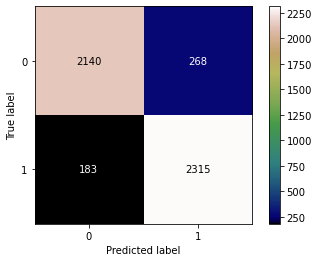

The Accurracy score is 0.9080717488789237
The Sensitivity score is 0.9267413931144916
The Precision score is 0.8962446767324816


In [42]:
preds = nb.predict(X_test_c)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

plot_confusion_matrix(nb, X_test_c, y_test, cmap='gist_earth', values_format='d');
plt.show()
print(f'The Accurracy score is {metrics.accuracy_score(y_test, preds)}')
print(f'The Sensitivity score is {metrics.recall_score(y_test, preds)}')
print(f'The Precision score is {metrics.precision_score(y_test, preds)}')

As with the earlier models we see that Sensitivity is optimized in this model compared to Precision. This means the model is slightly better at avoiding False Negatives than avoiding False Positives. To restate that in context of our data, it's slightly more likely that a post classified as "not-Playstation", i.e. Xbox, is correct than it is that something we classified as "Playstation" is truly Playstation.

In [43]:
coef_df = pd.DataFrame(nb.coef_, columns = cvec.get_feature_names())
coef_df.T.sort_values(by=0)

,0
made xbox,-12.835950
better pc,-12.835950
gp ultimate,-12.835950
problem posting,-12.835950
grammar,-12.835950
...,...
playstation,-4.912964
game,-4.818642
ps5,-4.761612
games,-4.685771


Simply put, it appears all of my 20_000 coefficients were negative, meaning the inverse relationships to our target 1 (Playstation) were stronger than any positive options.

In [44]:
coef_df.T[0].value_counts().head(10)

-11.449655    2418
-11.226512    2379
-11.737338    2166
-11.044190    1856
-12.142803    1432
-12.835950    1413
-10.890040    1290
-10.756508     925
-10.638725     704
-10.533365     554
Name: 0, dtype: int64

These are the 10 most frequently recurring coefficients - some appear over 2_000 times! Clearly a lot of these words appeared not only the same proportion of times but also nearly exclusively in the Xbox (0) subreddit.

In [45]:
coef_df.T.sort_values(by=0).head(10)

,0
made xbox,-12.83595
better pc,-12.83595
gp ultimate,-12.83595
problem posting,-12.83595
grammar,-12.83595
beta xbox,-12.83595
beta support,-12.83595
beta pc,-12.83595
beta app,-12.83595
best xbox,-12.83595


There are 1432 coefficients tied for strongest coefficient! These are the first 10. It looks like the word "beta" makes several appearances in connection with the xbox subreddit.

### Model 10   
#### Random Forest  
I'm going to do a grid search to see how a random forest model performs on my data. To do this, I'll have to update my pipemaker() function to accept random forest as the classifier (done in .py file). I'll set the parameters in a dictionary below.

In [46]:
#referred to Lesson 6.03
pipe_rf_params = {
    'rf__n_estimators': [75,100,125], #number of trees in my forest
    'rf__min_samples_split':[2],  #min number of samples required before a split
    'rf__min_samples_leaf': [1], #min number of samples that can be on one leaf
    'rf__max_features': [None,'auto'], #None performs like a tranditional bagging model, auto is sqrt of features
    'rf__max_depth': [None,5,6,7,8], #regulate depth of tree branches to combat overfit by not going too deep
    'rf__random_state': [17] #set random state
}

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  9.0min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 21.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 38.5min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 58.6min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 83.4min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 112.3min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 147.1min
[Parallel(n_jobs=10)]: Done 3240 out of 3240 | elapsed: 148.8min finished


The best parameters are: {'cvec__max_df': 0.4, 'cvec__max_features': 15000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',

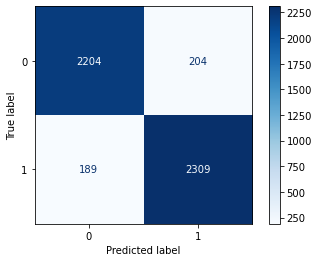

The Accurracy score is 0.9198940073379536
The Sensitivity score is 0.9243394715772618
The Precision score is 0.9188221249502586
____________________
Receiver Operating Characteristic (ROC) curve:


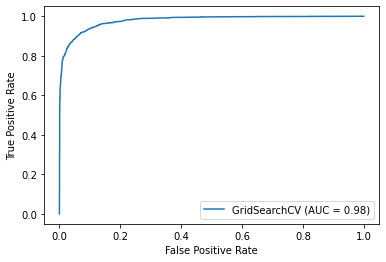

'Model scored!'

In [47]:
maxfeats = [15_000, 20_000] #try different volume of features
mindf = [3, 4, 5] #minimum word frequency to be included in the model
maxdf = [.4, .5, .8] #cutoff for words more frequent than percentage (float) threshhold 
ngrams = [(1,2), (1,3)] #range of combinations of words to try (minimum, maximum) 
swords = [stopwords.words('english')]
scaler = 'cvec' #continuing with cvec
classifier = 'rf' #<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW CLASSIFIER, Random Forest

pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

#params.update(pipe_rf_params) #<<<<<<<<<<<<<<<<<<<<concatenate my two parameter dictionaries

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=10,        #<<<<<<<<<<<<<<<CHANGE: upping to 10 cores
                  #cv=3, verbose=1) #<<<<<<<<<<<<<CHANGE: reduced to 3 cv folds for faster processing

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() output:  
[Parallel(n_jobs=10)]: Done 3240 out of 3240 | elapsed: 148.8min finished !!!!!!!

The best parameters are: {'cvec__max_df': 0.4, 'cvec__max_features': 15000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': (stop word list), 'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'rf__random_state': 17}  
The best training score was: 0.9217913560530914  
The test score is: 0.9198940073379536  
____________________
Confusion Matrix for Test Set: (not shown here)  

The Accurracy score is 0.9198940073379536  
The Sensitivity score is 0.9243394715772618  
The Precision score is 0.9188221249502586  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown here)  

'Model scored!'

Wow, that took over 2 hours to run! It looks like overall model accuracy did improve, as well as my Precision which had been lower in all prior models. This seems like a more balanced model overall. I'm going to re-run it using just the grid-searched ideal hyperparameters outside of the pipeline so I can examine the relative feature importance more precisely.

### Model 11

In [49]:
cvec = CountVectorizer(max_features=15_000,
                       min_df=4, 
                       max_df = .4,
                       ngram_range=(1,2),
                       stop_words=stopwords.words('english'))
X_train_c = cvec.fit_transform(X_train)
X_test_c = cvec.transform(X_test)
#only use best hyperparameters that above grid search preferred
rf = RandomForestClassifier(n_estimators=100,
                           min_samples_split = 2,
                           min_samples_leaf = 1,
                           max_features = 'auto',
                           max_depth = None,
                           random_state = 17)

rf.fit(X_train_c, y_train)

print(f'The best training score was: {rf.score(X_train_c, y_train)}')
print(f'The test score is: {rf.score(X_test_c, y_test)}')

The best training score was: 0.9997961541074948
The test score is: 0.9198940073379536


Oddly, this model seems to have higher overfit than the gridsearched ideal model with the same parameters. Regardless, my test scor is still a solid ~92% which beats all prior models.

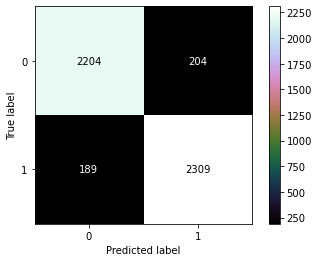

The Accurracy score is 0.9198940073379536
The Sensitivity score is 0.9243394715772618
The Precision score is 0.9188221249502586


In [98]:
preds = rf.predict(X_test_c)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

plot_confusion_matrix(rf, X_test_c, y_test, cmap='cubehelix', values_format='d');
plt.show()
print(f'The Accurracy score is {metrics.accuracy_score(y_test, preds)}')
print(f'The Sensitivity score is {metrics.recall_score(y_test, preds)}')
print(f'The Precision score is {metrics.precision_score(y_test, preds)}')

This confusion matrix shows how strong the model is. The False Negatives (189) and False Positives (204) are very similar, suggesting that the model is well balanced.

In [ ]:
#https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e

In [85]:
feat_imp = pd.DataFrame(rf.feature_importances_,
                                   index = cvec.get_feature_names(),
                                    columns=['importance']).sort_values('importance',ascending=False)

In [91]:
#print(feat_imp.head(10).to_markdown())

|             |   importance |
|:------------|-------------:|
| xbox        |    0.114827  |
| ps4         |    0.0623533 |
| playstation |    0.04113   |
| ps5         |    0.0340841 |
| series      |    0.0224452 |
| xbox one    |    0.0168698 |
| ps          |    0.0160656 |
| sony        |    0.0120391 |
| psn         |    0.0119337 |
| microsoft   |    0.0117509 |

Here are the top 10 most important features from this Random Forest model.